/home/baha/anaconda3/envs/gym-env/lib/python3.10/site-packages/gymnasium/experimental/wrappers/jax_to_numpy.py:75: DeprecationWarning: jax.numpy.DeviceArray is deprecated. Use jax.Array.
  @jax_to_numpy.register(jnp.DeviceArray)
/home/baha/anaconda3/envs/gym-env/lib/python3.10/site-packages/gymnasium/experimental/wrappers/jax_to_torch.py:105: DeprecationWarning: jax.numpy.DeviceArray is deprecated. Use jax.Array.
  @jax_to_torch.register(jnp.DeviceArray)
pybullet build time: Nov  6 2023 16:28:13
2024-01-19 15:46:04.405219: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/baha/.local/lib/python3.10/site-packages/cv2/../../lib64::/home/baha/.mujoco/mujoco210/bin
2024-01-19 15:46:05.128424: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libn

1.0


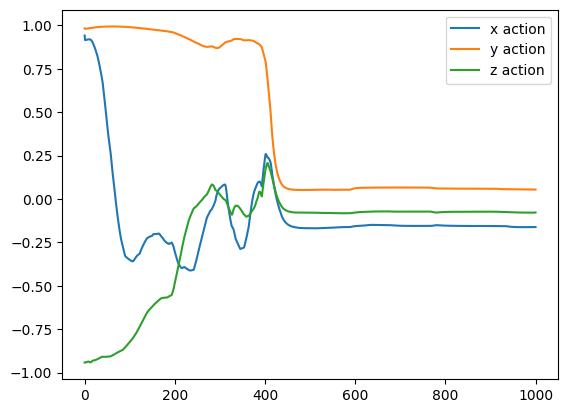

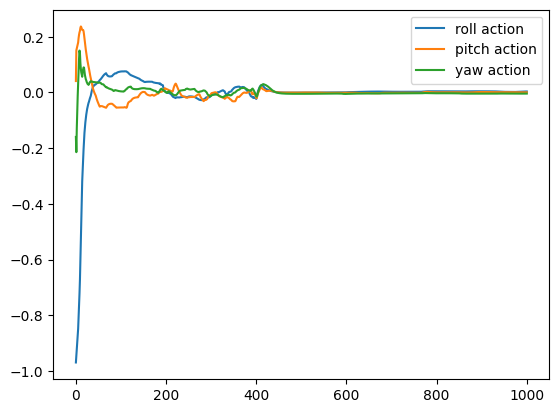

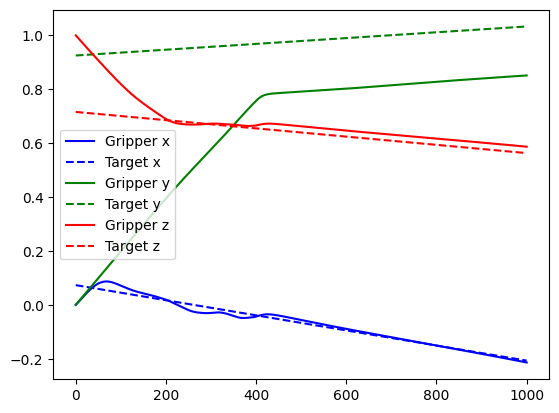

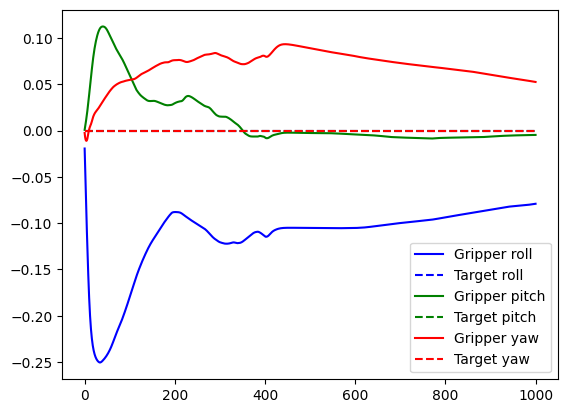

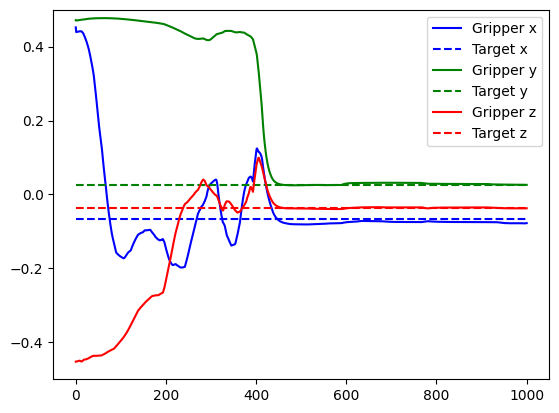

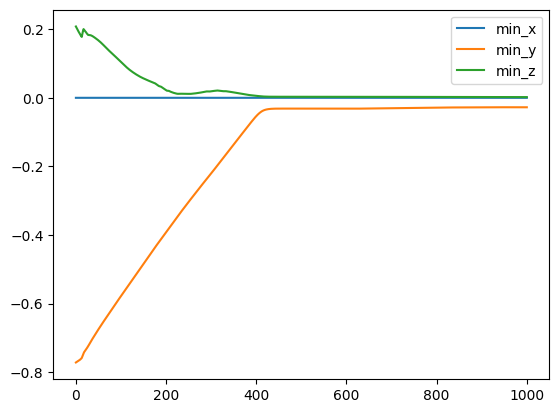

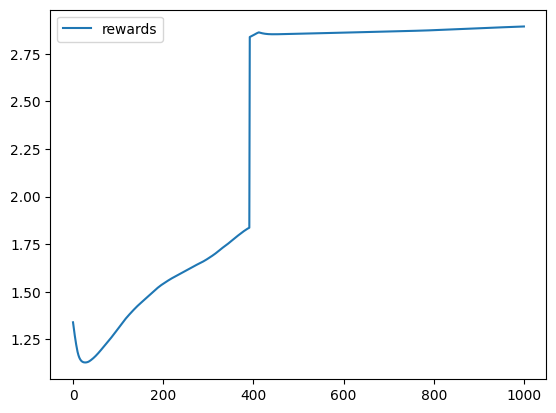

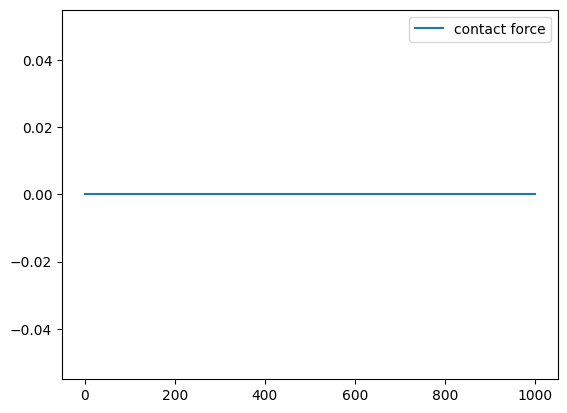

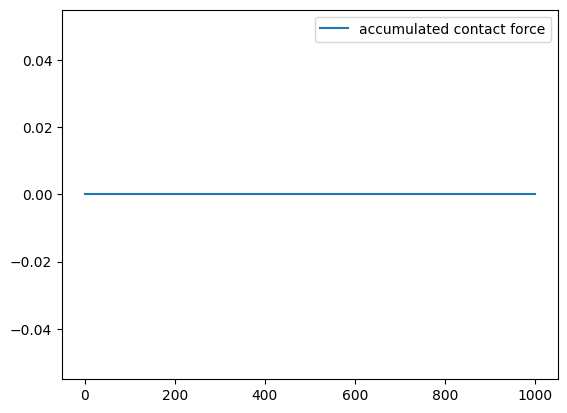

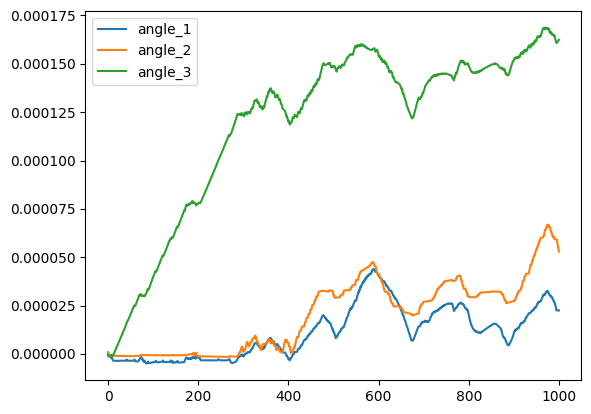

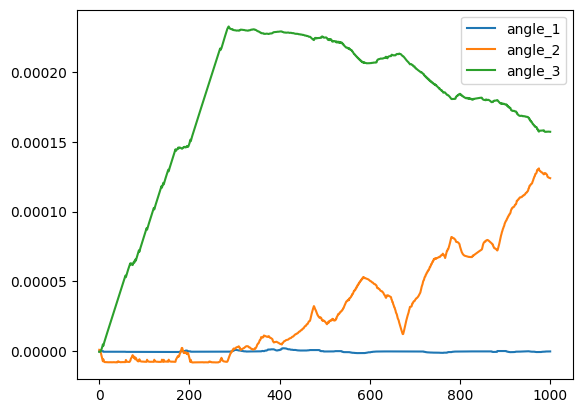

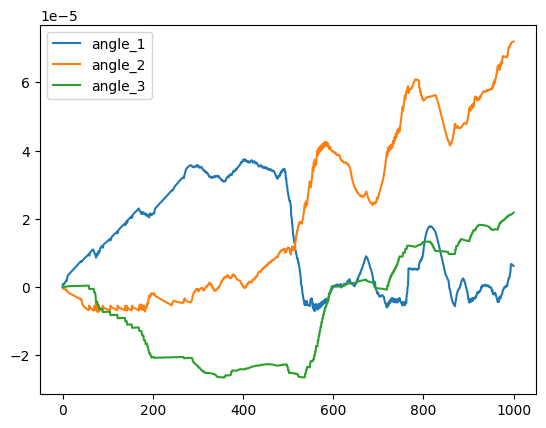

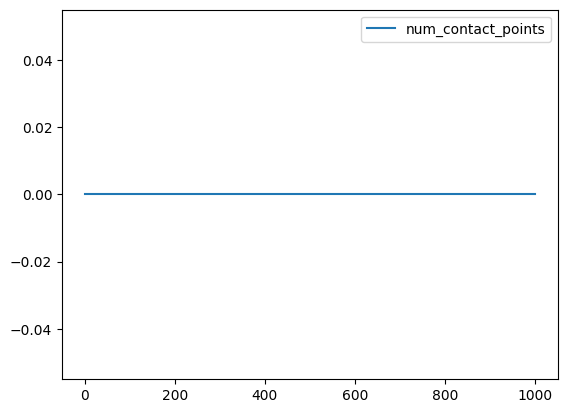

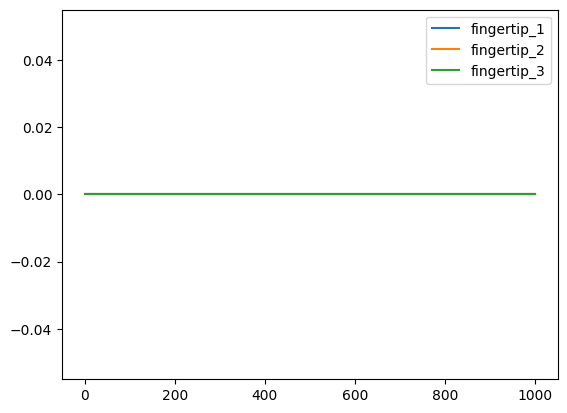

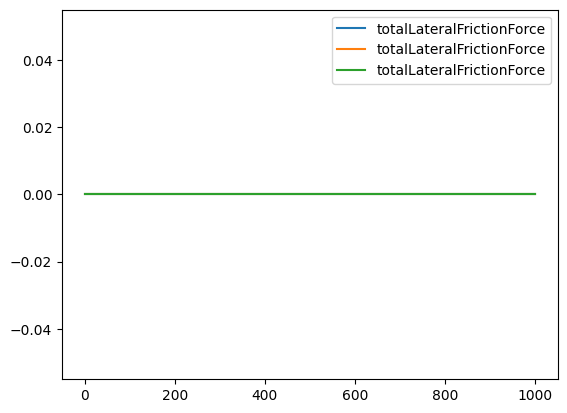

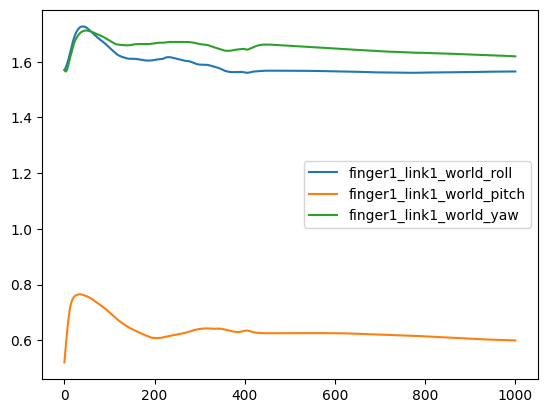

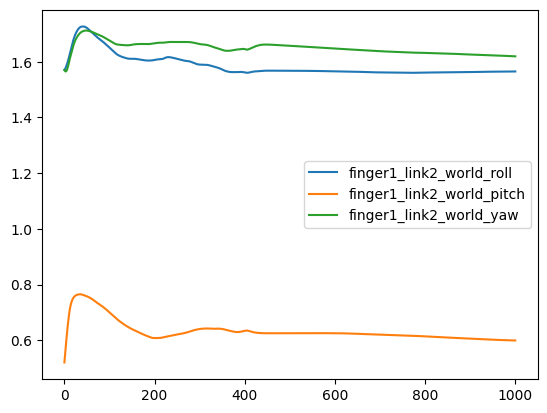

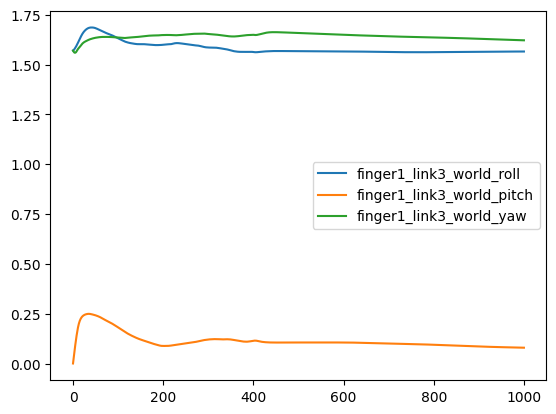

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
import gymnasium
sys.modules["gym"] = gymnasium
import pybullet as p
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from robotiqGymEnv import robotiqGymEnv
import numpy as np
import csv

def load_model(file_path):
    """
    Load the model from the given file path.
    """
    return SAC.load(file_path)

def extract_data(env, model, obs):
    """
    Extract data from the environment.
    """
    data = {
        "position_action": [],
        "angle_action": [],
        "gripper_position": [],
        "gripper_angle": [],
        "gripper_velocity": [],
        "gripper_angular_velocity": [],
        "target_position": [],
        "target_angle": [],
        "target_velocity": [],
        "target_angular_velocity": [],
        "closest_point": [],
        "contact_force": [],
        "rewards": [],
        "finger1_angles": [],
        "finger2_angles": [],
        "finger3_angles": [],
        "finger1_min_dists": [],
        "finger2_min_dists": [],
        "finger3_min_dists": [],
        "num_contact_points": [],
        "fingertip_num_contact_points": [],
        "accumulated_contact_force": [],
        "totalLateralFrictionForce": [],
        "finger1_link1_world_angles": [],
        "finger1_link2_world_angles": [],
        "finger1_link3_world_angles": [],
    }

    done = False

    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, done, info = env.step(action)
        
        finger1_link1_world_angles = np.array(p.getEulerFromQuaternion(p.getLinkState(env._robotiq.robotiq_uid, 2)[1]))
        finger1_link2_world_angles = np.array(p.getEulerFromQuaternion(p.getLinkState(env._robotiq.robotiq_uid, 3)[1]))
        finger1_link3_world_angles = np.array(p.getEulerFromQuaternion(p.getLinkState(env._robotiq.robotiq_uid, 4)[1]))
        
        base_pos = obs[0:3]
        gripper_angle = obs[3:6]
        base_velocity = obs[6:9]
        base_angular_velocity = obs[9:12]
        target_pos = obs[12:15]
        target_angle = obs[15:18]
        target_velocity = obs[24:27]
        target_angular_velocity = obs[27:30]
        closest_point = obs[36:39]

        joint_indices = [1, 2, 3, 5, 6, 7, 9, 10, 11]
        joint_states = p.getJointStates(env._robotiq.robotiq_uid, joint_indices)
        
        finger1_angle = np.array([np.float64(joint_states[0][0]), np.float64(joint_states[1][0]), np.float64(joint_states[2][0])])
        finger2_angle = np.array([np.float64(joint_states[3][0]), np.float64(joint_states[4][0]), np.float64(joint_states[5][0])])
        finger3_angle = np.array([np.float64(joint_states[6][0]), np.float64(joint_states[7][0]), np.float64(joint_states[8][0])])
        
        data["finger1_angles"].append(finger1_angle)
        data["finger2_angles"].append(finger2_angle)
        data["finger3_angles"].append(finger3_angle)
                
        dist_indices = [1, 2, 3, 5, 6, 7, 9, 10, 11]
        min_dists = [p.getClosestPoints(env.blockUid, env._robotiq.robotiq_uid, 10, -1, i)[0][8] for i in dist_indices]
        min_dists = np.array(min_dists)
                
        data["finger1_min_dists"].append(min_dists[0:3])
        data["finger2_min_dists"].append(min_dists[3:6])
        data["finger3_min_dists"].append(min_dists[6:9])
        data["position_action"].append(action[0:3])
        data["angle_action"].append(action[3:6])
        data["gripper_position"].append(base_pos)
        data["gripper_angle"].append(gripper_angle)
        data["gripper_velocity"].append(base_velocity)
        data["gripper_angular_velocity"].append(base_angular_velocity)
        data["target_position"].append(target_pos)
        data["target_angle"].append(target_angle)
        data["target_velocity"].append(target_velocity)
        data["target_angular_velocity"].append(target_angular_velocity)
        data["closest_point"].append(closest_point)
        data["contact_force"].append(env._contactinfo()[5])
        data["num_contact_points"].append(env._contactinfo()[3])
        data["fingertip_num_contact_points"].append(env._contactinfo()[4])
        data["rewards"].append(rewards)
        data["accumulated_contact_force"].append(env._accumulated_contact_force)
        data["totalLateralFrictionForce"].append(env._contactinfo()[2])
        data["finger1_link1_world_angles"].append(finger1_link1_world_angles)
        data["finger1_link2_world_angles"].append(finger1_link2_world_angles)
        data["finger1_link3_world_angles"].append(finger1_link3_world_angles)
        
        # env.render()
    print(info["is_success"])
    return data

def plot_data(data, labels):
    """
    Plot the data using matplotlib.
    """
    plt.figure()
    for d, label in zip(data, labels):
        plt.plot(d, label=label)
        plt.legend()

def plot_combined_data(data_gripper, data_target, labels, upper_bound=None, lower_bound=None):
    """
    Plot gripper and target data on the same plot with the same color for each direction.
    Gripper data will be solid lines, target data will be dashed lines.
    """
    plt.figure()  # You can adjust the size if you want

    colors = ['b', 'g', 'r']  # blue, green, red for x, y, z respectively
    line_styles = ['-', '--']  # solid for gripper, dashed for target

    for i, (d_gripper, d_target, label) in enumerate(zip(data_gripper, data_target, labels)):
        color = colors[i % len(colors)]
        plt.plot(d_gripper, line_styles[0], color=color, label=f'Gripper {label}')
        plt.plot(d_target, line_styles[1], color=color, label=f'Target {label}')
        if upper_bound is not None and lower_bound is not None:
            plt.ylim(lower_bound, upper_bound)
        plt.legend()

def save_to_csv(filename, data):
    """
    Save data to CSV.
    """
    # Find the maximum length among all lists
    max_length = max(len(v) for v in data.values())

    with open(filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)

        # Write header
        headers = list(data.keys())
        csv_writer.writerow(headers)

        # Write rows
        for i in range(max_length):
            row = [data[header][i] if i < len(data[header]) else "" for header in headers]
            csv_writer.writerow(row)

def main():
    """
    Main function to run the program.
    """
    model_file = "models/20230316-03:42PM_SAC/best_model.zip"
    model = load_model(model_file)

    with robotiqGymEnv(records=False, renders=False) as env:
        obs = env.reset()
        # steps = range(500)  # Define the number of steps here
        data = extract_data(env, model, obs)

    # Plotting data
    plot_data(zip(*data["position_action"]), ["x action", "y action", "z action"])
    plot_data(zip(*data["angle_action"]), ["roll action", "pitch action", "yaw action"])
    plot_combined_data(zip(*data["gripper_position"]),zip(*data["target_position"]),["x", "y", "z"])
    plot_combined_data(zip(*data["gripper_angle"]),zip(*data["target_angle"]),["roll", "pitch", "yaw"])
    plot_combined_data(zip(*data["gripper_velocity"]),zip(*data["target_velocity"]),["x", "y", "z"], upper_bound=0.5, lower_bound=-0.5)
    plot_data(zip(*data["closest_point"]), ["min_x", "min_y", "min_z"]) 
    plot_data([data["rewards"]], ["rewards"])
    plot_data([data["contact_force"]], ["contact force"])
    plot_data([data["accumulated_contact_force"]], ["accumulated contact force"])
    plot_data(zip(*data["finger1_angles"]), ["angle_1", "angle_2", "angle_3"])
    plot_data(zip(*data["finger2_angles"]), ["angle_1", "angle_2", "angle_3"])
    plot_data(zip(*data["finger3_angles"]), ["angle_1", "angle_2", "angle_3"])
    plot_data([data["num_contact_points"]], ["num_contact_points"])
    plot_data(zip(*data["fingertip_num_contact_points"]), ["fingertip_1", "fingertip_2", "fingertip_3"])
    plot_data([data["totalLateralFrictionForce"]], ["totalLateralFrictionForce"])
    plot_data(zip(*data["finger1_link1_world_angles"]), ["finger1_link1_world_roll", "finger1_link1_world_pitch", "finger1_link1_world_yaw"])
    plot_data(zip(*data["finger1_link2_world_angles"]), ["finger1_link2_world_roll", "finger1_link2_world_pitch", "finger1_link2_world_yaw"])
    plot_data(zip(*data["finger1_link3_world_angles"]), ["finger1_link3_world_roll", "finger1_link3_world_pitch", "finger1_link3_world_yaw"])
    # plot_data(zip(*data["finger2_min_dists"]), ["finger2_min_dist_1", "finger2_min_dist_2", "finger2_min_dist_3"])

    # Saving data to CSV
    save_to_csv("output_data.csv", data)
    

    # Calculating and printing final positions
    gripper_position_data = np.array(data["gripper_position"])
    gripper_final_position = np.mean(gripper_position_data[-100:, :], axis=0)
    target_position_data = np.array(data["target_position"])
    target_final_position = np.mean(target_position_data[-100:, :], axis=0)

    D = 2628.9
    sat = 476.6
    robot_gripper_pose = [gripper_final_position[1] * 1000, gripper_final_position[0] * 1000, gripper_final_position[2] * 1000]
    robot_sat_pose = [D - sat - target_final_position[1] * 1000 - 100, -target_final_position[0] * 1000, target_final_position[2] * 1000 + 30]

    # print("robot gripper pose: ", robot_gripper_pose)
    # print("robot sat pose: ", robot_sat_pose)

if __name__ == "__main__":
    main()
